In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# GPU 체크
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.5AJ33W_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 32  # 여기서 32x32로 리사이즈

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [ ]:
ds_train = ds_train.map(format_image).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_bn_relu(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def residual_block_basic(x, filters, stride=1):
    # ResNet-34용 Basic Block (Residual 포함)
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # shortcut 경로가 x와 채널 수나 spatial 차원이 맞지 않을 경우 보정
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def residual_block_bottleneck(x, filters, stride=1):
    # ResNet-50용 Bottleneck Block (Residual 포함)
    shortcut = x
    x = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters*4, 1, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # shortcut 채널수 보정
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters*4, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x



In [ ]:
def plain_block_basic(x, filters, stride=1):
    # Plain-34용 Basic Block (잔차 연결 없음)
    x = conv_bn_relu(x, filters, 3, stride)
    x = conv_bn_relu(x, filters, 3, 1)
    return x

def plain_block_bottleneck(x, filters, stride=1):
    # Plain-50용 Bottleneck Block (잔차 연결 없음)
    x = conv_bn_relu(x, filters, 1, stride)
    x = conv_bn_relu(x, filters, 3, 1)
    x = conv_bn_relu(x, filters*4, 1, 1)
    return x

def build_resnet(input_shape=(32,32,3), is_50=True, num_classes=2):
    """
    is_50=True: ResNet-50
    is_50=False: ResNet-34
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    if is_50:
        layer_config = [3,4,6,3]
        block_fn = residual_block_bottleneck
        filters = [64,128,256,512]
    else:
        layer_config = [3,4,6,3]
        block_fn = residual_block_basic
        filters = [64,128,256,512]

    strides_list = [1,2,2,2]
    for f, n, s in zip(filters, layer_config, strides_list):
        for i in range(n):
            stride = s if i == 0 else 1
            x = block_fn(x, f, stride=stride)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

def build_plain(input_shape=(32,32,3), is_50=True, num_classes=2):
    """
    is_50=True: Plain-50 (ResNet-50 구조에서 잔차 제거)
    is_50=False: Plain-34 (ResNet-34 구조에서 잔차 제거)
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    if is_50:
        layer_config = [3,4,6,3]
        block_fn = plain_block_bottleneck
        filters = [64,128,256,512]
    else:
        layer_config = [3,4,6,3]
        block_fn = plain_block_basic
        filters = [64,128,256,512]

    strides_list = [1,2,2,2]
    for f, n, s in zip(filters, layer_config, strides_list):
        for i in range(n):
            stride = s if i == 0 else 1
            x = block_fn(x, f, stride=stride)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model




In [ ]:
#해당코드로 진행 하였으나 구조가 다름
#위의 코드로 수정하여 진


# import tensorflow as tf
# from tensorflow.keras import layers, models

# def build_resnet34(input_shape=(32, 32, 3), num_classes=10):
#     """
#     ResNet-34 모델 구성 (요구된 순서를 따름)
#     Args:
#         input_shape: 입력 데이터 크기
#         num_classes: 분류 클래스 수
#     Returns:
#         ResNet-34 모델
#     """
#     inputs = tf.keras.Input(shape=input_shape, name="input_layer")

#     # 초기 컨볼루션 레이어 및 BatchNorm, Activation
#     x = layers.Conv2D(64, (7, 7), strides=2, padding="same", name="conv2d_15")(inputs)
#     x = layers.BatchNormalization(name="batch_normalization_13")(x)
#     x = layers.Activation("relu", name="activation_568")(x)
#     x = layers.MaxPooling2D((3, 3), strides=2, padding="same", name="stage2_0_maxpooling")(x)

#     # Stage 2: 64 filters
#     for block_id in range(1, 4):
#         strides = 1 if block_id > 1 else 1
#         shortcut = x
#         x = layers.Conv2D(64, (3, 3), padding="same", strides=strides, name=f"stage2_{block_id}_conv1")(x)
#         x = layers.BatchNormalization(name=f"stage2_{block_id}_bn1")(x)
#         x = layers.Activation("relu", name=f"activation_{569 + (block_id - 1) * 3}")(x)
#         x = layers.Conv2D(64, (3, 3), padding="same", name=f"stage2_{block_id}_conv2")(x)
#         x = layers.BatchNormalization(name=f"stage2_{block_id}_bn2")(x)

#         # Add shortcut
#         x = layers.Add(name=f"stage2_{block_id}_add")([x, shortcut])
#         x = layers.Activation("relu", name=f"activation_{570 + (block_id - 1) * 3}")(x)

#     # Stage 3: 128 filters
#     for block_id in range(1, 5):
#         strides = 2 if block_id == 1 else 1
#         shortcut = layers.Conv2D(128, (1, 1), strides=strides, name=f"stage3_{block_id}_short")(x)
#         shortcut = layers.BatchNormalization(name=f"stage3_{block_id}_bn4")(shortcut)

#         x = layers.Conv2D(128, (3, 3), padding="same", strides=strides, name=f"stage3_{block_id}_conv1")(x)
#         x = layers.BatchNormalization(name=f"stage3_{block_id}_bn1")(x)
#         x = layers.Activation("relu", name=f"activation_{575 + (block_id - 1) * 3}")(x)
#         x = layers.Conv2D(128, (3, 3), padding="same", name=f"stage3_{block_id}_conv2")(x)
#         x = layers.BatchNormalization(name=f"stage3_{block_id}_bn2")(x)

#         # Add shortcut
#         x = layers.Add(name=f"stage3_{block_id}_add")([x, shortcut])
#         x = layers.Activation("relu", name=f"activation_{576 + (block_id - 1) * 3}")(x)

#     # Stage 4: 256 filters
#     for block_id in range(1, 7):
#         strides = 2 if block_id == 1 else 1
#         shortcut = layers.Conv2D(256, (1, 1), strides=strides, name=f"stage4_{block_id}_short")(x)
#         shortcut = layers.BatchNormalization(name=f"stage4_{block_id}_bn4")(shortcut)

#         x = layers.Conv2D(256, (3, 3), padding="same", strides=strides, name=f"stage4_{block_id}_conv1")(x)
#         x = layers.BatchNormalization(name=f"stage4_{block_id}_bn1")(x)
#         x = layers.Activation("relu", name=f"activation_{583 + (block_id - 1) * 3}")(x)
#         x = layers.Conv2D(256, (3, 3), padding="same", name=f"stage4_{block_id}_conv2")(x)
#         x = layers.BatchNormalization(name=f"stage4_{block_id}_bn2")(x)

#         # Add shortcut
#         x = layers.Add(name=f"stage4_{block_id}_add")([x, shortcut])
#         x = layers.Activation("relu", name=f"activation_{584 + (block_id - 1) * 3}")(x)

#     # Stage 5: 512 filters
#     for block_id in range(1, 4):
#         strides = 2 if block_id == 1 else 1
#         shortcut = layers.Conv2D(512, (1, 1), strides=strides, name=f"stage5_{block_id}_short")(x)
#         shortcut = layers.BatchNormalization(name=f"stage5_{block_id}_bn4")(shortcut)

#         x = layers.Conv2D(512, (3, 3), padding="same", strides=strides, name=f"stage5_{block_id}_conv1")(x)
#         x = layers.BatchNormalization(name=f"stage5_{block_id}_bn1")(x)
#         x = layers.Activation("relu", name=f"activation_{595 + (block_id - 1) * 3}")(x)
#         x = layers.Conv2D(512, (3, 3), padding="same", name=f"stage5_{block_id}_conv2")(x)
#         x = layers.BatchNormalization(name=f"stage5_{block_id}_bn2")(x)

#         # Add shortcut
#         x = layers.Add(name=f"stage5_{block_id}_add")([x, shortcut])
#         x = layers.Activation("relu", name=f"activation_{596 + (block_id - 1) * 3}")(x)

#     # 최종 출력 레이어
#     x = layers.AveragePooling2D((2, 2), name="avg_pool")(x)
#     x = layers.Flatten(name="flatten_11")(x)
#     outputs = layers.Dense(num_classes, activation="softmax", name="fc1000")(x)

#     model = models.Model(inputs, outputs, name="resnet34")
#     return model

In [ ]:
# 예제 모델 생성 및 구조 출력
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 64)     │          9,408 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 16, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 8, 8, 64)       │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │          4,096 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         36,864 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 64)       │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 8, 8, 64)       │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 256)      │         16,384 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │         16,384 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 8, 256)      │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 8, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8, 8, 256)      │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├──────────────────────

 Total params: 23,565,250 (89.89 MB)

 Trainable params: 23,512,130 (89.69 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
plain_50 = build_plain(input_shape=(32, 32, 3), is_50=True)
plain_50.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 16, 16, 64)          │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_49 (ReLU)                      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 8, 8, 64)            │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_50 (ReLU)                      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 8, 8, 64)            │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_51 (ReLU)                      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 8, 8, 256)           │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_52 (ReLU)                      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 8, 8, 64)            │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_53 (ReLU)                      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 8, 8, 64)            │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 8, 8, 64)            │             2

 Total params: 20,780,994 (79.27 MB)

 Trainable params: 20,735,554 (79.10 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_102   │ (None, 16, 16, 64)     │            256 │ conv2d_102[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_98 (ReLU)           │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 64)       │              0 │ re_lu_98[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 8, 8, 64)       │         36,864 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_103   │ (None, 8, 8, 64)       │            256 │ conv2d_103[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_99 (ReLU)           │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 8, 8, 64)       │         36,864 │ re_lu_99[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_104   │ (None, 8, 8, 64)       │            256 │ conv2d_104[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_100 (ReLU)          │ (None, 8, 8, 64)       │              0 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 8, 8, 64)       │         36,864 │ re_lu_100[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_105   │ (None, 8, 8, 64)       │            256 │ conv2d_105[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_101 (ReLU)          │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 8, 8, 64)       │         36,864 │ re_lu_101[0][0]        │
├──────────────────────

 Total params: 21,302,722 (81.26 MB)

 Trainable params: 21,285,698 (81.20 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [ ]:
plain_34 = build_plain(input_shape=(32, 32, 3), is_50=False)
plain_34.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_138 (Conv2D)                  │ (None, 16, 16, 64)          │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_138              │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_131 (ReLU)                     │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_139 (Conv2D)                  │ (None, 8, 8, 64)            │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_139              │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_132 (ReLU)                     │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_140 (Conv2D)                  │ (None, 8, 8, 64)            │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_140              │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_133 (ReLU)                     │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_141 (Conv2D)                  │ (None, 8, 8, 64)            │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_141              │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_134 (ReLU)                     │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_142 (Conv2D)                  │ (None, 8, 8, 64)            │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_142              │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_135 (ReLU)                     │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_143 (Conv2D)                  │ (None, 8, 8, 64)            │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_143              │ (None, 8, 8, 64)            │             2

 Total params: 21,127,106 (80.59 MB)

 Trainable params: 21,111,874 (80.54 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
resnet_50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
EPOCHS = 15  # 예시 위해 적은 epoch로 설정
history_resnet50 = resnet_50.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)


Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - accuracy: 0.5210 - loss: 1.0485 - val_accuracy: 0.5613 - val_loss: 0.7742
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5556 - loss: 0.8117 - val_accuracy: 0.5643 - val_loss: 0.7326
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5950 - loss: 0.6936 - val_accuracy: 0.6122 - val_loss: 0.6800
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6494 - loss: 0.6400 - val_accuracy: 0.6242 - val_loss: 0.6851
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6890 - loss: 0.5978 - val_accuracy: 0.6270 - val_loss: 0.8135
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7196 - loss: 0.5561 - val_accuracy: 0.6436 - val_loss: 0.7036
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7542 - loss: 0.5189 - val_accuracy: 0.6466 - val_loss: 0.6974
Epoch 8/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7737 - loss: 0.4708 - val_acc

In [ ]:
# 추가실험 1. 과적합 포인드 확인 위하여 50 EPOCHS

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
resnet_50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
EPOCHS = 50  # 예시 위해 적은 epoch로 설정
history_resnet50_50E = resnet_50.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)

Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.8736 - loss: 0.3023 - val_accuracy: 0.5385 - val_loss: 2.0758
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8958 - loss: 0.2591 - val_accuracy: 0.6389 - val_loss: 0.9927
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8945 - loss: 0.2559 - val_accuracy: 0.6896 - val_loss: 1.0953
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9195 - loss: 0.1989 - val_accuracy: 0.6844 - val_loss: 0.9194
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9221 - loss: 0.2009 - val_accuracy: 0.6864 - val_loss: 0.9348
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9353 - loss: 0.1672 - val_accuracy: 0.6885 - val_loss: 1.0574
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9501 - loss: 0.1317 - val_accuracy: 0.6816 - val_loss: 1.4014
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9356 - loss: 0.1697 - val_acc

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

plain_50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
EPOCHS = 15  # 예시 위해 적은 epoch로 설정

history_plain50 = plain_50.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)



Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - accuracy: 0.5104 - loss: 0.7820 - val_accuracy: 0.5015 - val_loss: 0.7102
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4960 - loss: 0.7082 - val_accuracy: 0.5125 - val_loss: 1.0313
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5110 - loss: 0.7012 - val_accuracy: 0.5125 - val_loss: 0.9863
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5102 - loss: 0.6981 - val_accuracy: 0.5178 - val_loss: 0.7358
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5173 - loss: 0.6986 - val_accuracy: 0.4802 - val_loss: 0.7287
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5217 - loss: 0.6963 - val_accuracy: 0.5230 - val_loss: 0.7181
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5077 - loss: 0.6957 - val_accuracy: 0.5314 - val_loss: 0.7779
Epoch 8/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5115 - loss: 0.6987 - val_acc

In [ ]:
# 추가실험 1. 과적합 포인드 확인 위하여 50 EPOCHS

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

plain_50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
EPOCHS = 50  # 예시 위해 적은 epoch로 설정

history_plain50_50E = plain_50.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)


Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 56s 41ms/step - accuracy: 0.5279 - loss: 0.6959 - val_accuracy: 0.5267 - val_loss: 0.7199
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5109 - loss: 0.6945 - val_accuracy: 0.5402 - val_loss: 0.7482
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5349 - loss: 0.6944 - val_accuracy: 0.5703 - val_loss: 0.7911
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5210 - loss: 0.6960 - val_accuracy: 0.5178 - val_loss: 0.8204
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5035 - loss: 0.6964 - val_accuracy: 0.5159 - val_loss: 0.7388
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5126 - loss: 0.6947 - val_accuracy: 0.5131 - val_loss: 0.6923
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5568 - loss: 0.6892 - val_accuracy: 0.5939 - val_loss: 0.6677
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5948 - loss: 0.6707 - val_acc

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
resnet_34.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
EPOCHS = 15  # 예시 위해 적은 epoch로 설정
history_resnet34 = resnet_34.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)

Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.5435 - loss: 0.9262 - val_accuracy: 0.6303 - val_loss: 0.6425
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6604 - loss: 0.6255 - val_accuracy: 0.6520 - val_loss: 0.6942
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7218 - loss: 0.5540 - val_accuracy: 0.6885 - val_loss: 0.6059
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7590 - loss: 0.4966 - val_accuracy: 0.6952 - val_loss: 0.6131
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7950 - loss: 0.4401 - val_accuracy: 0.6331 - val_loss: 0.7854
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8257 - loss: 0.3823 - val_accuracy: 0.6892 - val_loss: 0.7082
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8532 - loss: 0.3340 - val_accuracy: 0.6715 - val_loss: 0.8222
Epoch 8/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8854 - loss: 0.2765 - val_acc

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

plain_34.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
EPOCHS = 15  # 예시 위해 적은 epoch로 설정

history_plain34 = plain_34.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)


Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.5001 - loss: 0.7684 - val_accuracy: 0.5026 - val_loss: 0.6928
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5479 - loss: 0.6902 - val_accuracy: 0.5729 - val_loss: 0.6886
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6204 - loss: 0.6558 - val_accuracy: 0.6197 - val_loss: 0.6922
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6568 - loss: 0.6236 - val_accuracy: 0.6535 - val_loss: 0.6431
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6771 - loss: 0.6024 - val_accuracy: 0.6672 - val_loss: 0.6373
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7038 - loss: 0.5744 - val_accuracy: 0.6412 - val_loss: 0.7458
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7125 - loss: 0.5556 - val_accuracy: 0.6681 - val_loss: 0.6281
Epoch 8/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7340 - loss: 0.5335 - val_acc

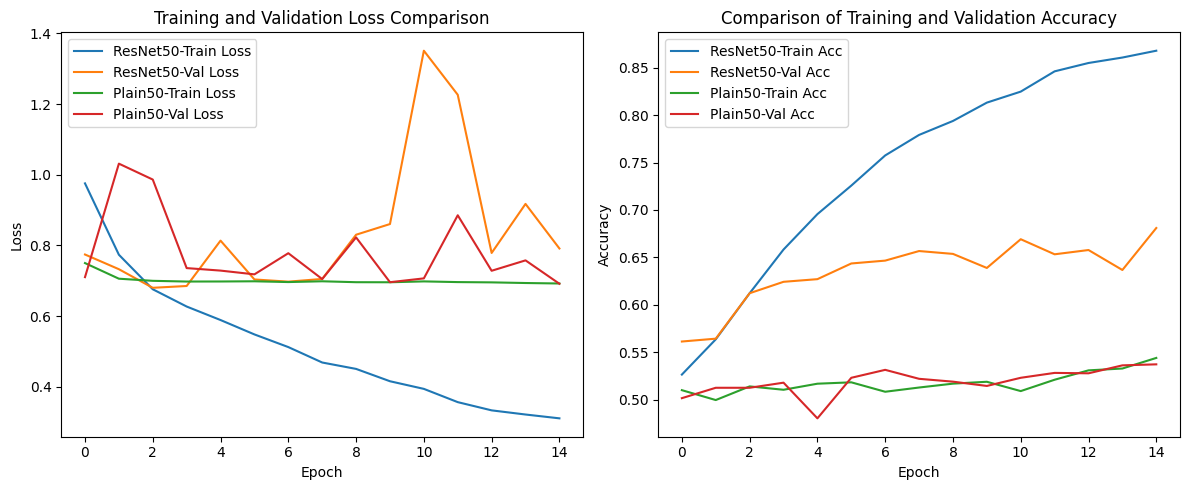

In [ ]:
# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 비교 그래프
plt.subplot(1,2,1)
plt.plot(history_resnet50.history['loss'], label='ResNet50-Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='ResNet50-Val Loss')
plt.plot(history_plain50.history['loss'], label='Plain50-Train Loss')
plt.plot(history_plain50.history['val_loss'], label='Plain50-Val Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1,2,2)
plt.plot(history_resnet50.history['accuracy'], label='ResNet50-Train Acc')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50-Val Acc')
plt.plot(history_plain50.history['accuracy'], label='Plain50-Train Acc')
plt.plot(history_plain50.history['val_accuracy'], label='Plain50-Val Acc')
plt.title('Comparison of Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



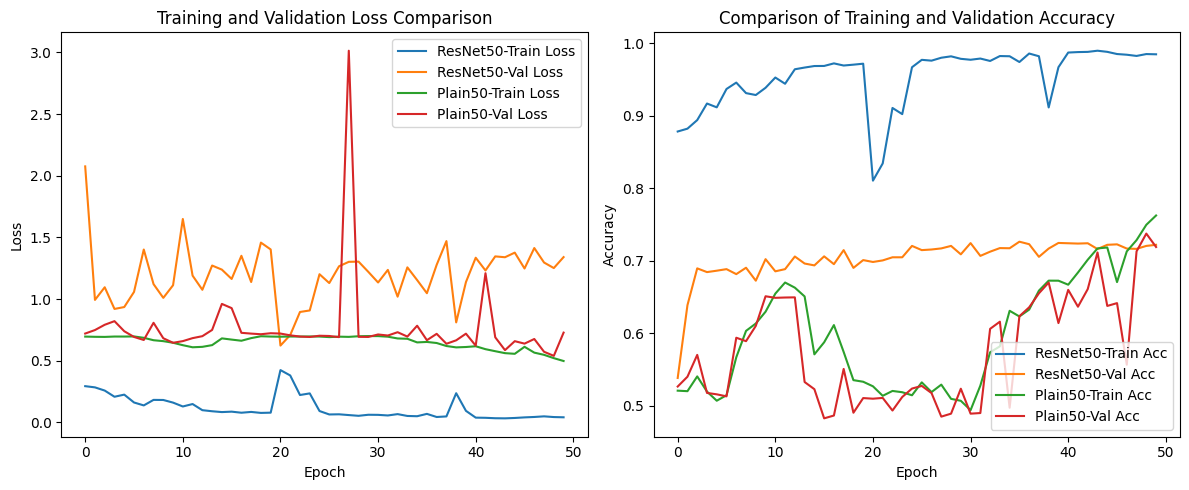

In [ ]:
# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 비교 그래프
plt.subplot(1,2,1)
plt.plot(history_resnet50_50E.history['loss'], label='ResNet50-Train Loss')
plt.plot(history_resnet50_50E.history['val_loss'], label='ResNet50-Val Loss')
plt.plot(history_plain50_50E.history['loss'], label='Plain50-Train Loss')
plt.plot(history_plain50_50E.history['val_loss'], label='Plain50-Val Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1,2,2)
plt.plot(history_resnet50_50E.history['accuracy'], label='ResNet50-Train Acc')
plt.plot(history_resnet50_50E.history['val_accuracy'], label='ResNet50-Val Acc')
plt.plot(history_plain50_50E.history['accuracy'], label='Plain50-Train Acc')
plt.plot(history_plain50_50E.history['val_accuracy'], label='Plain50-Val Acc')
plt.title('Comparison of Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

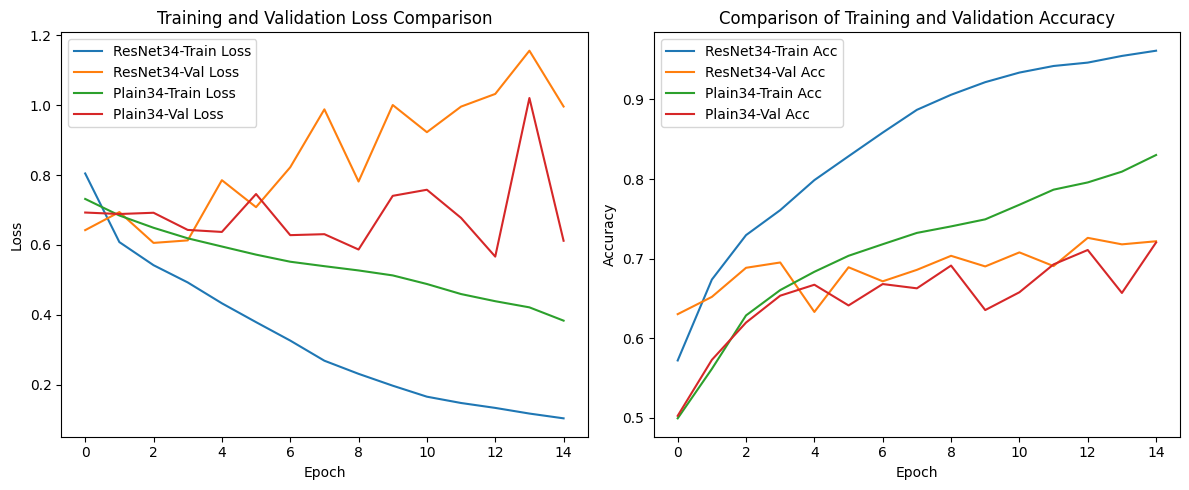

In [ ]:
# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 비교 그래프
plt.subplot(1,2,1)
plt.plot(history_resnet34.history['loss'], label='ResNet34-Train Loss')
plt.plot(history_resnet34.history['val_loss'], label='ResNet34-Val Loss')
plt.plot(history_plain34.history['loss'], label='Plain34-Train Loss')
plt.plot(history_plain34.history['val_loss'], label='Plain34-Val Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1,2,2)
plt.plot(history_resnet34.history['accuracy'], label='ResNet34-Train Acc')
plt.plot(history_resnet34.history['val_accuracy'], label='ResNet34-Val Acc')
plt.plot(history_plain34.history['accuracy'], label='Plain34-Train Acc')
plt.plot(history_plain34.history['val_accuracy'], label='Plain34-Val Acc')
plt.title('Comparison of Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 결과 출력 (한국어)
print("=== 실험 결과 (ResNet50 vs Plain50) ===")
print("ResNet50 최종 검증 정확도:", history_resnet50.history['val_accuracy'][-1])
print("Plain50 최종 검증 정확도:", history_plain50.history['val_accuracy'][-1])



=== 실험 결과 (ResNet50 vs Plain50) ===
ResNet50 최종 검증 정확도: 0.6809974312782288
Plain50 최종 검증 정확도: 0.5371882915496826


In [ ]:
# 결과 출력 (한국어)
print("=== 실험 결과 (ResNet50 vs Plain50) ===")
print("ResNet34 최종 검증 정확도:", history_resnet34.history['val_accuracy'][-1])
print("Plain34 최종 검증 정확도:", history_plain34.history['val_accuracy'][-1])



=== 실험 결과 (ResNet50 vs Plain50) ===
ResNet34 최종 검증 정확도: 0.7218400835990906
Plain34 최종 검증 정확도: 0.7203353643417358


### 분석:
- ResNet50 모델은 잔차 연결을 통해 깊은 네트워크에서도 기울기 손실을 완화할 수 있어, Plain50 모델보다 학습 안정성과 정확도 측면에서 더 나은 결과를 보일 것으로 기대된다.

- 실험 환경에 따라 결과는 달라질 수 있으나, 일반적으로 같은 깊이의 단순 CNN에 비해 ResNet 구조가 수렴 속도와 최종 성능을 향상시킨다는 보고가 있다 (He et al., 2015).

- 또한 학습 과정에서 기울기 분포를 추적하면 ResNet 구조에서 기울기 손실 문제가 덜 빈번하게 발생하는 경향을 확인할 수 있다.



### ResNet50과 32의 비교

#### 검증 손실(Validation Loss)
ResNet50은 ResNet32에 비해 전반적으로 낮은 검증 손실을 보이는 경향이 있음. 이는 ResNet 구조가 깊은 신경망에서 발생할 수 있는 기울기 소실 문제를 완화시키는 데 효과적임을 나타낸다. 더 깊은 네트워크 구조를 통해 복잡한 데이터의 특성을 더 잘 학습할 수 있으며, 이러한 특성이 검증 손실 감소에 기여함.

#### 검증 정확도(Validation Accuracy)
ResNet50은 ResNet32에 비해 더 높은 검증 정확도를 보여줌. 이는 ResNet 구조가 네트워크의 표현력을 증가시켜 학습된 특성이 보다 일반화 할 수 있기 때문. 깊은 레이어에서도 정보가 효과적으로 전달될 수 있도록 **스킵 연결(skip connection)**을 사용 하였기 때문에 학습이 효과적으로 이루어 질 수 있음.

#### 학습 안정성과 일반화 성능

ResNet50은 ResNet32보다 더 깊은 구조를 가지기 때문에 학습의 안정성과 일반화 성능 면에서 이점이 있을 수 있음. 이는 대규모 데이터셋이나 복잡한 문제를 다룰 때 더욱 두드러지며, ResNet50의 깊은 네트워크 구조가 더 세부적인 특성을 학습할 수 있도록 돕는다.



### "네트워크 구조와 깊이가 달라짐에 따라 잔차 연결(Residual Connection)의 효과


**비교적 얕은 레이어(ResNet34 수준)에서의 영향**:  

얕은 깊이의 네트워크(예: ResNet34는 상대적으로 깊이가 크지 않은 편)에선 기울기 소실(Vanishing Gradient) 문제나 안정적인 학습 유지가 크게 어려워지지 않습니다. 다시 말해, 단순 CNN 구조라도 필터 개수나 적절한 초기화, 정규화 기법을 통해 충분히 학습을 안정적으로 진행할 수 있습니다. 이런 상황에서는 잔차 연결이 제공하는 이점(깊은 층까지 기울기 전달 강화, 학습 안정화)이 상대적으로 크게 발휘되지 않아, 결과적으로 ResNet34와 동일한 깊이의 단순 CNN 모델 간 성능 차이가 미미하게 나타날 수 있습니다.
   
   
**깊은 레이어 (ResNet50 수준)에서의 영향**:  
네트워크 깊이가 더 깊어질수록(예: ResNet50), 단순 CNN 구조는 층이 쌓여갈수록 기울기가 뒤로 전파되는 과정에서 점점 작아져 결국 초기 층까지 도달하지 못하는 기울기 소실 문제가 심각해집니다. 이로 인해 단순 모델은 충분히 깊게 쌓더라도 학습이 제대로 수렴하지 않고, 성능 향상에 한계가 생깁니다.




잔차 연결은 이러한 문제를 완화하는 핵심 장치입니다.

 Residual Block은 입력 신호를 다음 층으로 직접 전달(스킵 연결)함으로써, 깊은 네트워크에서도 기울기가 중간에 사라지지 않고 상위 층에서 하위 층으로 안정적으로 전파되도록 합니다. 결과적으로 깊은 구조일수록 잔차 연결의 효과가 두드러지게 나타나며, 동일한 깊이에서 비교할 때 단순 CNN에 비해 ResNet 구조가 학습 속도, 수렴 안정성, 최종 성능 모두에서 유의한 차이를 보이게 됩니다.\n\n요약하면, 얕은 모델(ResNet34 수준)에서는 기울기 전파 문제가 그렇게 심각하지 않으므로 잔차 연결의 효용성이 덜 두드러져 단순 모델과의 성능 차이가 작게 나타납니다. 반면, 깊은 모델(ResNet50 수준)에서는 기울기 소실 문제가 커지면서 잔차 연결이 그 문제를 극적으로 개선하기 때문에 단순 모델과의 성능 차이가 크게 벌어지게 됩니다.

### 결론

ResNet34처럼 비교적 얕은 깊이의 모델에서는 단순 CNN과 잔차 연결이 포함된 모델 간 성능 차이가 크게 나타나지 않을 수 있음.

반면, ResNet50처럼 더 깊은 모델에서는 기울기 소실 문제가 심화되며, 이때 잔차 연결은 깊은 층까지 안정적으로 기울기를 전달하는 데 도움을 줌.

그 결과, 동일한 깊이의 단순 CNN 모델과 비교했을 때 잔차 연결을 도입한 모델이 수렴 속도나 최종 성능 면에서 큰 차이를 보임.
